In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Google Colab approach to importing custom module
# import sys
# sys.path.append('/content/drive/MyDrive/Colab Notebooks/wine_prices')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Custom module
from sommelier_says.data_processing import LoadData, PreprocessStrings

In [7]:
# Data preprocessing and visualization
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Natural language processing
import string
from nltk.corpus import stopwords 
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Deep learning
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Load data

FYI: the code for the custom module can be found in [my Git repository](https://github.com/elizabeth-oda/wine_prices/tree/main/wine_prices)


We'll use the Wine Tasting dataset [available on Kaggle](https://www.kaggle.com/mysarahmadbhat/wine-tasting)

In [8]:
# Adjust path based on your working directory
df = LoadData.load_data('../data/winemag-data-130k-v2.csv')

In [9]:
df.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [11]:
# Using df.copy() to avoid chained indexing
df = LoadData.clean_nan_strings(df)
df = LoadData.clean_nan_values(df)
df = LoadData.ohe_new_old_world(df)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129906 entries, 16 to 129481
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129906 non-null  object 
 1   description            129906 non-null  object 
 2   designation            129906 non-null  object 
 3   points                 129906 non-null  int64  
 4   price                  129906 non-null  float64
 5   province               129906 non-null  object 
 6   region_1               129906 non-null  object 
 7   region_2               129906 non-null  object 
 8   taster_name            129906 non-null  object 
 9   taster_twitter_handle  129906 non-null  object 
 10  title                  129906 non-null  object 
 11  variety                129906 non-null  object 
 12  winery                 129906 non-null  object 
 13  new_world              129906 non-null  bool   
 14  old_world              129906 non-n

In [13]:
df.describe()

,points,price
count,129906.000000,129906.000000
mean,88.447085,35.547989
std,3.040064,39.616034
min,80.000000,4.000000
25%,86.000000,18.000000
50%,88.000000,27.000000
75%,91.000000,41.139120
max,100.000000,3300.000000


## Preprocessing reviews for NLP

In [14]:
# Let's print a few example reviews to better understand the text data
rand_five = np.random.randint(low=0, high=len(df['description']), size=5)
for i in range(len(rand_five)):
    print(f"{df['description'][rand_five[i]]}\n")

Earthy and damp smelling, with chunky black cherry and olive aromas. The palate has a slightly choppy feel and then spicy, sweet flavors of herbs and blackberry. Finishes a little burnt and bitter, but overall there's enough sweetness and ripeness to offset any herbal qualities.

This winery produces a slew of Pinot Noirs each year, and this specific clonal study shows clove and cardamom on the somewhat subdued nose. The flavors are more forward, dominated by black tea and cherry, with a touch of tannin.

Produced in vineyards close to Mont Saint-Victoire in the west of the Provence vineyards, this perfumed, floral wine has crisp acidity along with orange and citrus flavors. The wine is light, very fruity and bright at the end.

This is the highlight of an excellent lineup from Stemilt Creek. It brings the same smooth, round fruit forward flavors as the other wines, but adds in more details with citrus, olive and green tea flavors streaking through. The finish gets downright sexy, with

In [15]:
# Make reviews lowercase
df['clean'] = df['description'].str.lower()

In [16]:
# Remove punctuation
# Adds em-dash (long hyphen) to default punctuation list
punc = string.punctuation
punc += '—'
def remove_punctuation(text):
    for p in punc:
        text = text.replace(p, ' ')
    return text

df['clean'] = df['clean'].apply(remove_punctuation)

In [17]:
df['clean'][0]

'aromas include tropical fruit  broom  brimstone and dried herb  the palate isn t overly expressive  offering unripened apple  citrus and dried sage alongside brisk acidity '

In [18]:
# Installs essential NLTK libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/elizabeth/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/elizabeth/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/elizabeth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
# Tokenize reviews and remove stopwords
# Stopwords are words that are so common that they are meaningless in topic analysis
stop_words = set(stopwords.words('english')) 

def remove_stopwords (text):
    tokenized = word_tokenize(text)
    without_stopwords = [word for word in tokenized if not word in stop_words]
    return without_stopwords

## Topic analysis with Latent Dirichlet Allocation (LDA)

In [21]:
# Overwrites X and y from the linear regression
# For now, our only feature is the description
X = df['clean']
y = df['points']

In [22]:
# Vectorizer uses the custom remove_stopwords function from earlier
vectorizer = CountVectorizer(tokenizer=remove_stopwords)
X = vectorizer.fit_transform(X)

In [26]:
# Instantiates and fits an LDA model with 20 components
lda_model = LatentDirichletAllocation(n_components=20).fit(X)

In [27]:
# Plotting function adapted from the LDA example provided by Scikit-Learn
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(5, 4, figsize=(45, 20), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

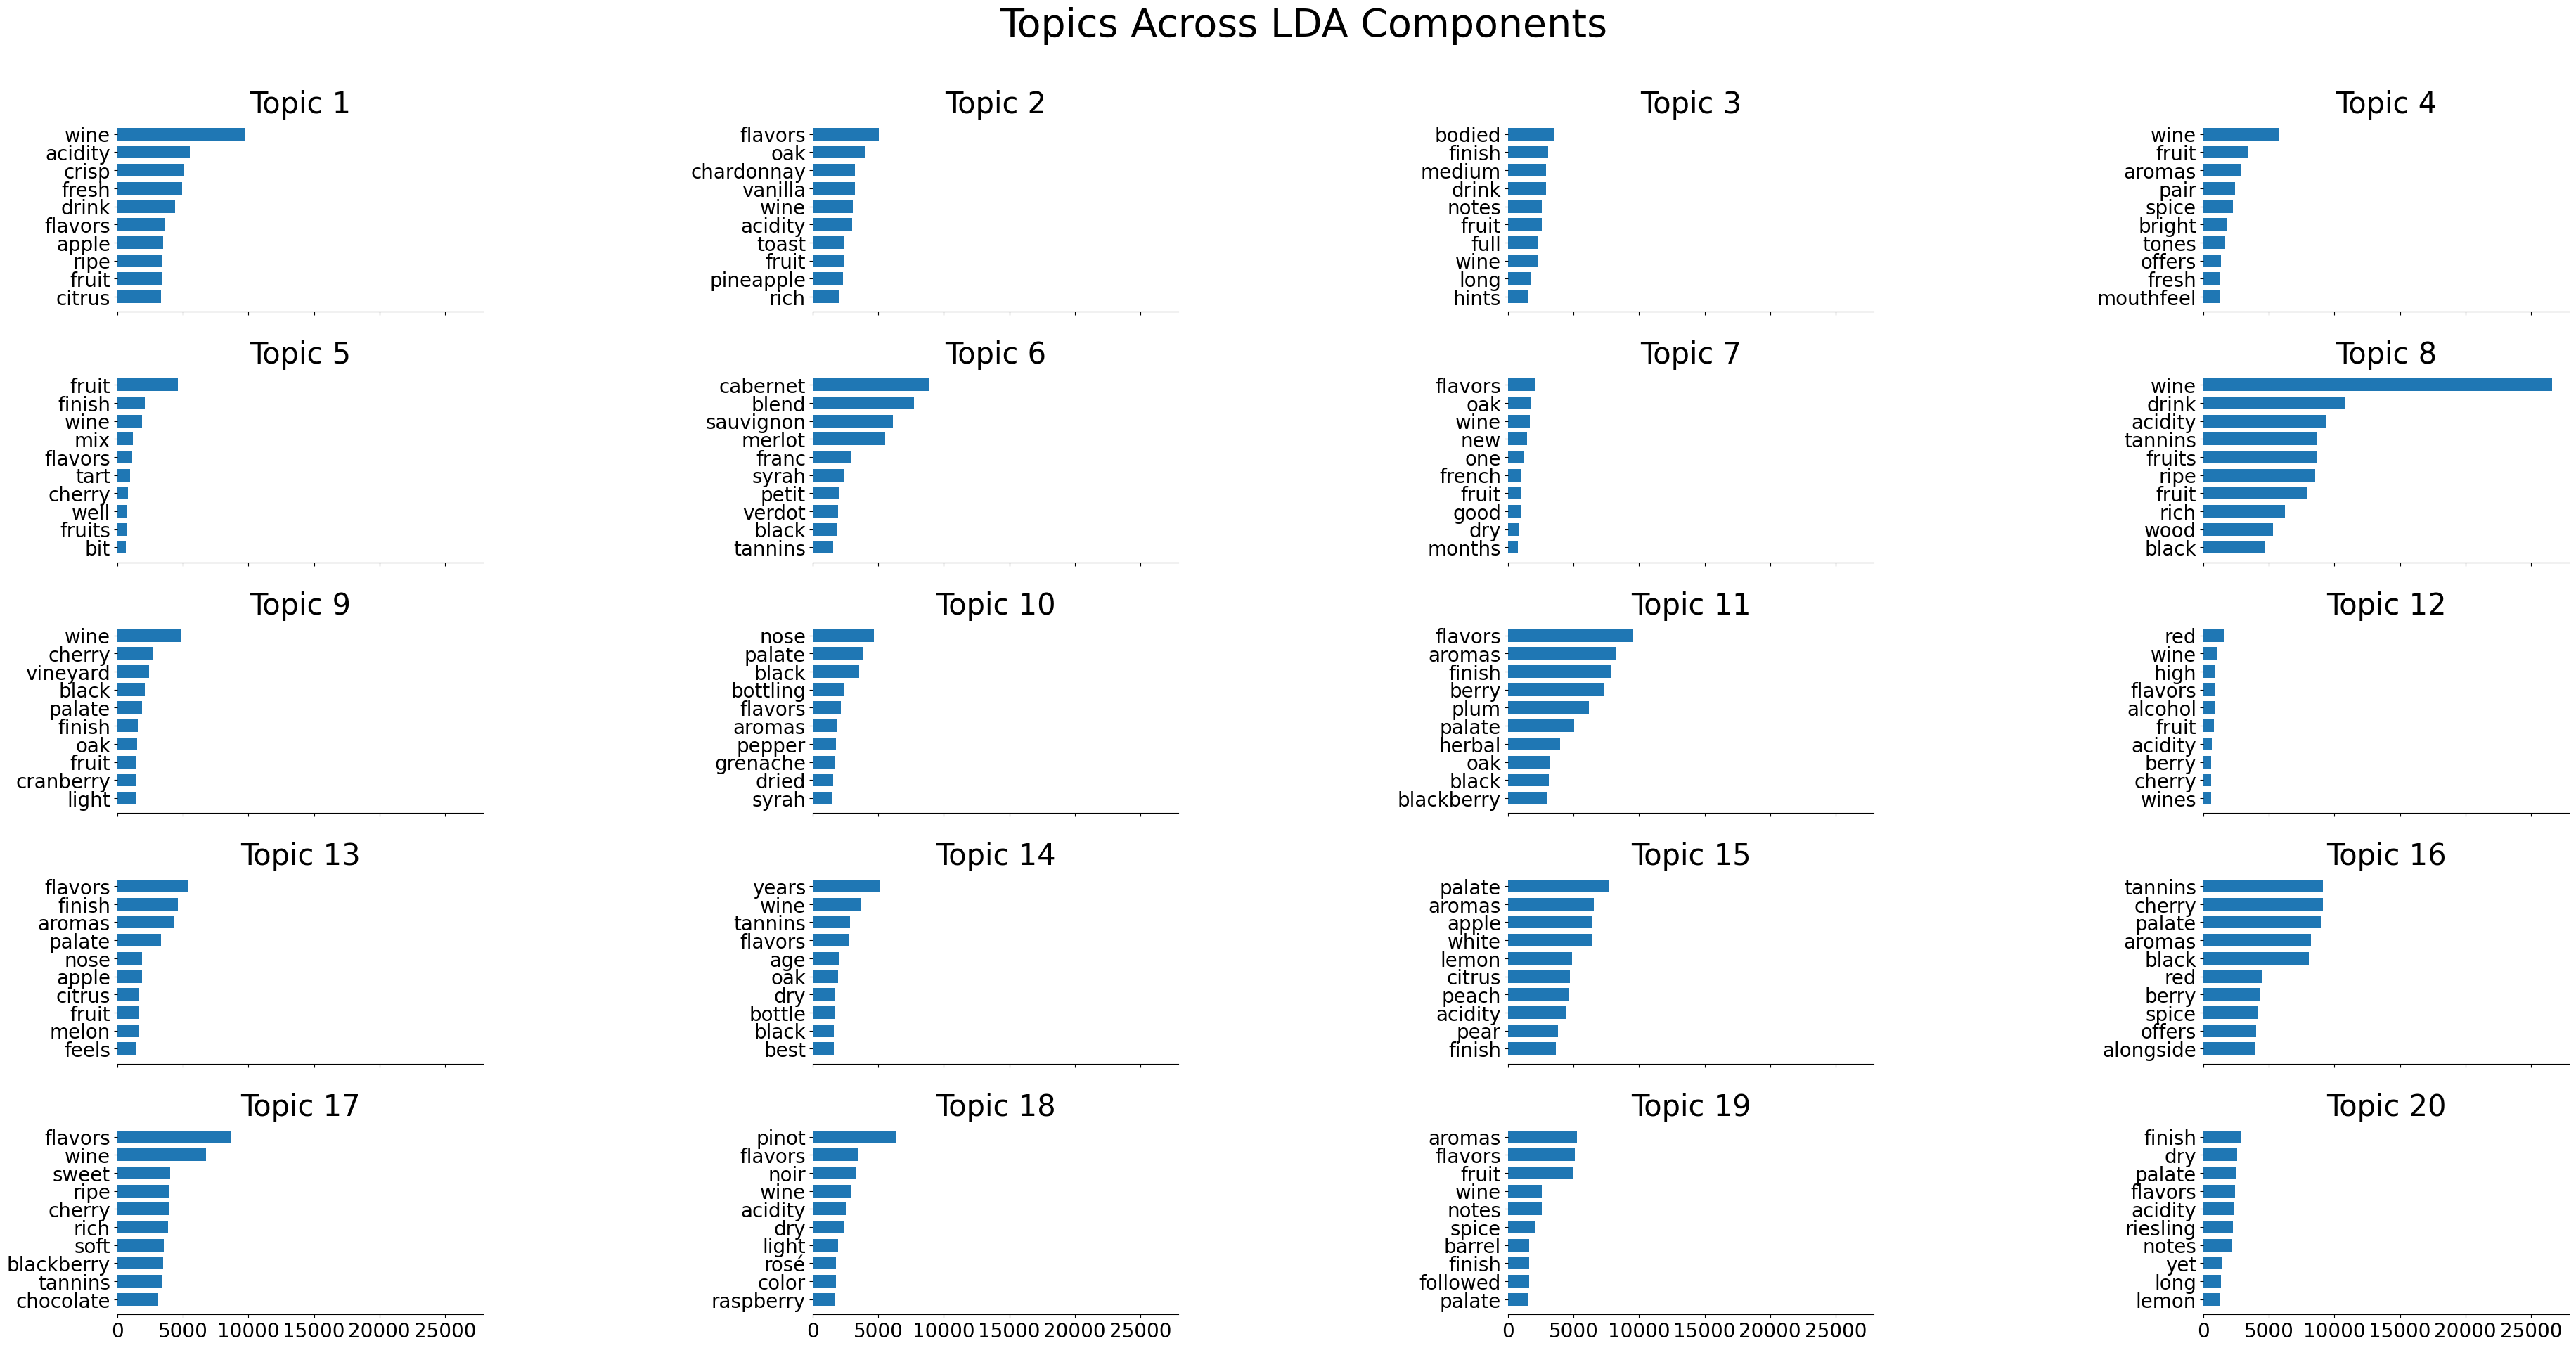

In [28]:
n_components = 20
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda_model, feature_names, n_top_words, "Topics Across LDA Components")

Based on the initial LDA, there are several words that are too frequent to be useful, such as:

* wine
* flavors
* aromas
* notes
* palate


In [29]:
# Refresh X and y
X = df['clean']
y = df['points']

In [30]:
# Append our stopwords list with wine-specific stopwords
wine_stopwords = stopwords.words('english')
custom_words = ['wine','flavors','aromas','notes','palate']
wine_stopwords.extend(custom_words)

def remove_wine_stopwords (text):
    tokenized = word_tokenize(text)
    without_stopwords = [word for word in tokenized if not word in wine_stopwords]
    return without_stopwords

In [31]:
# Create a new CountVectorizer instance that uses the updated stopwords list
updated_vectorizer = CountVectorizer(tokenizer=remove_wine_stopwords)
X = updated_vectorizer.fit_transform(X)

In [32]:
# Instantiates and fits a new LDA model with 20 components
lda_model_updated = LatentDirichletAllocation(n_components=20).fit(X)

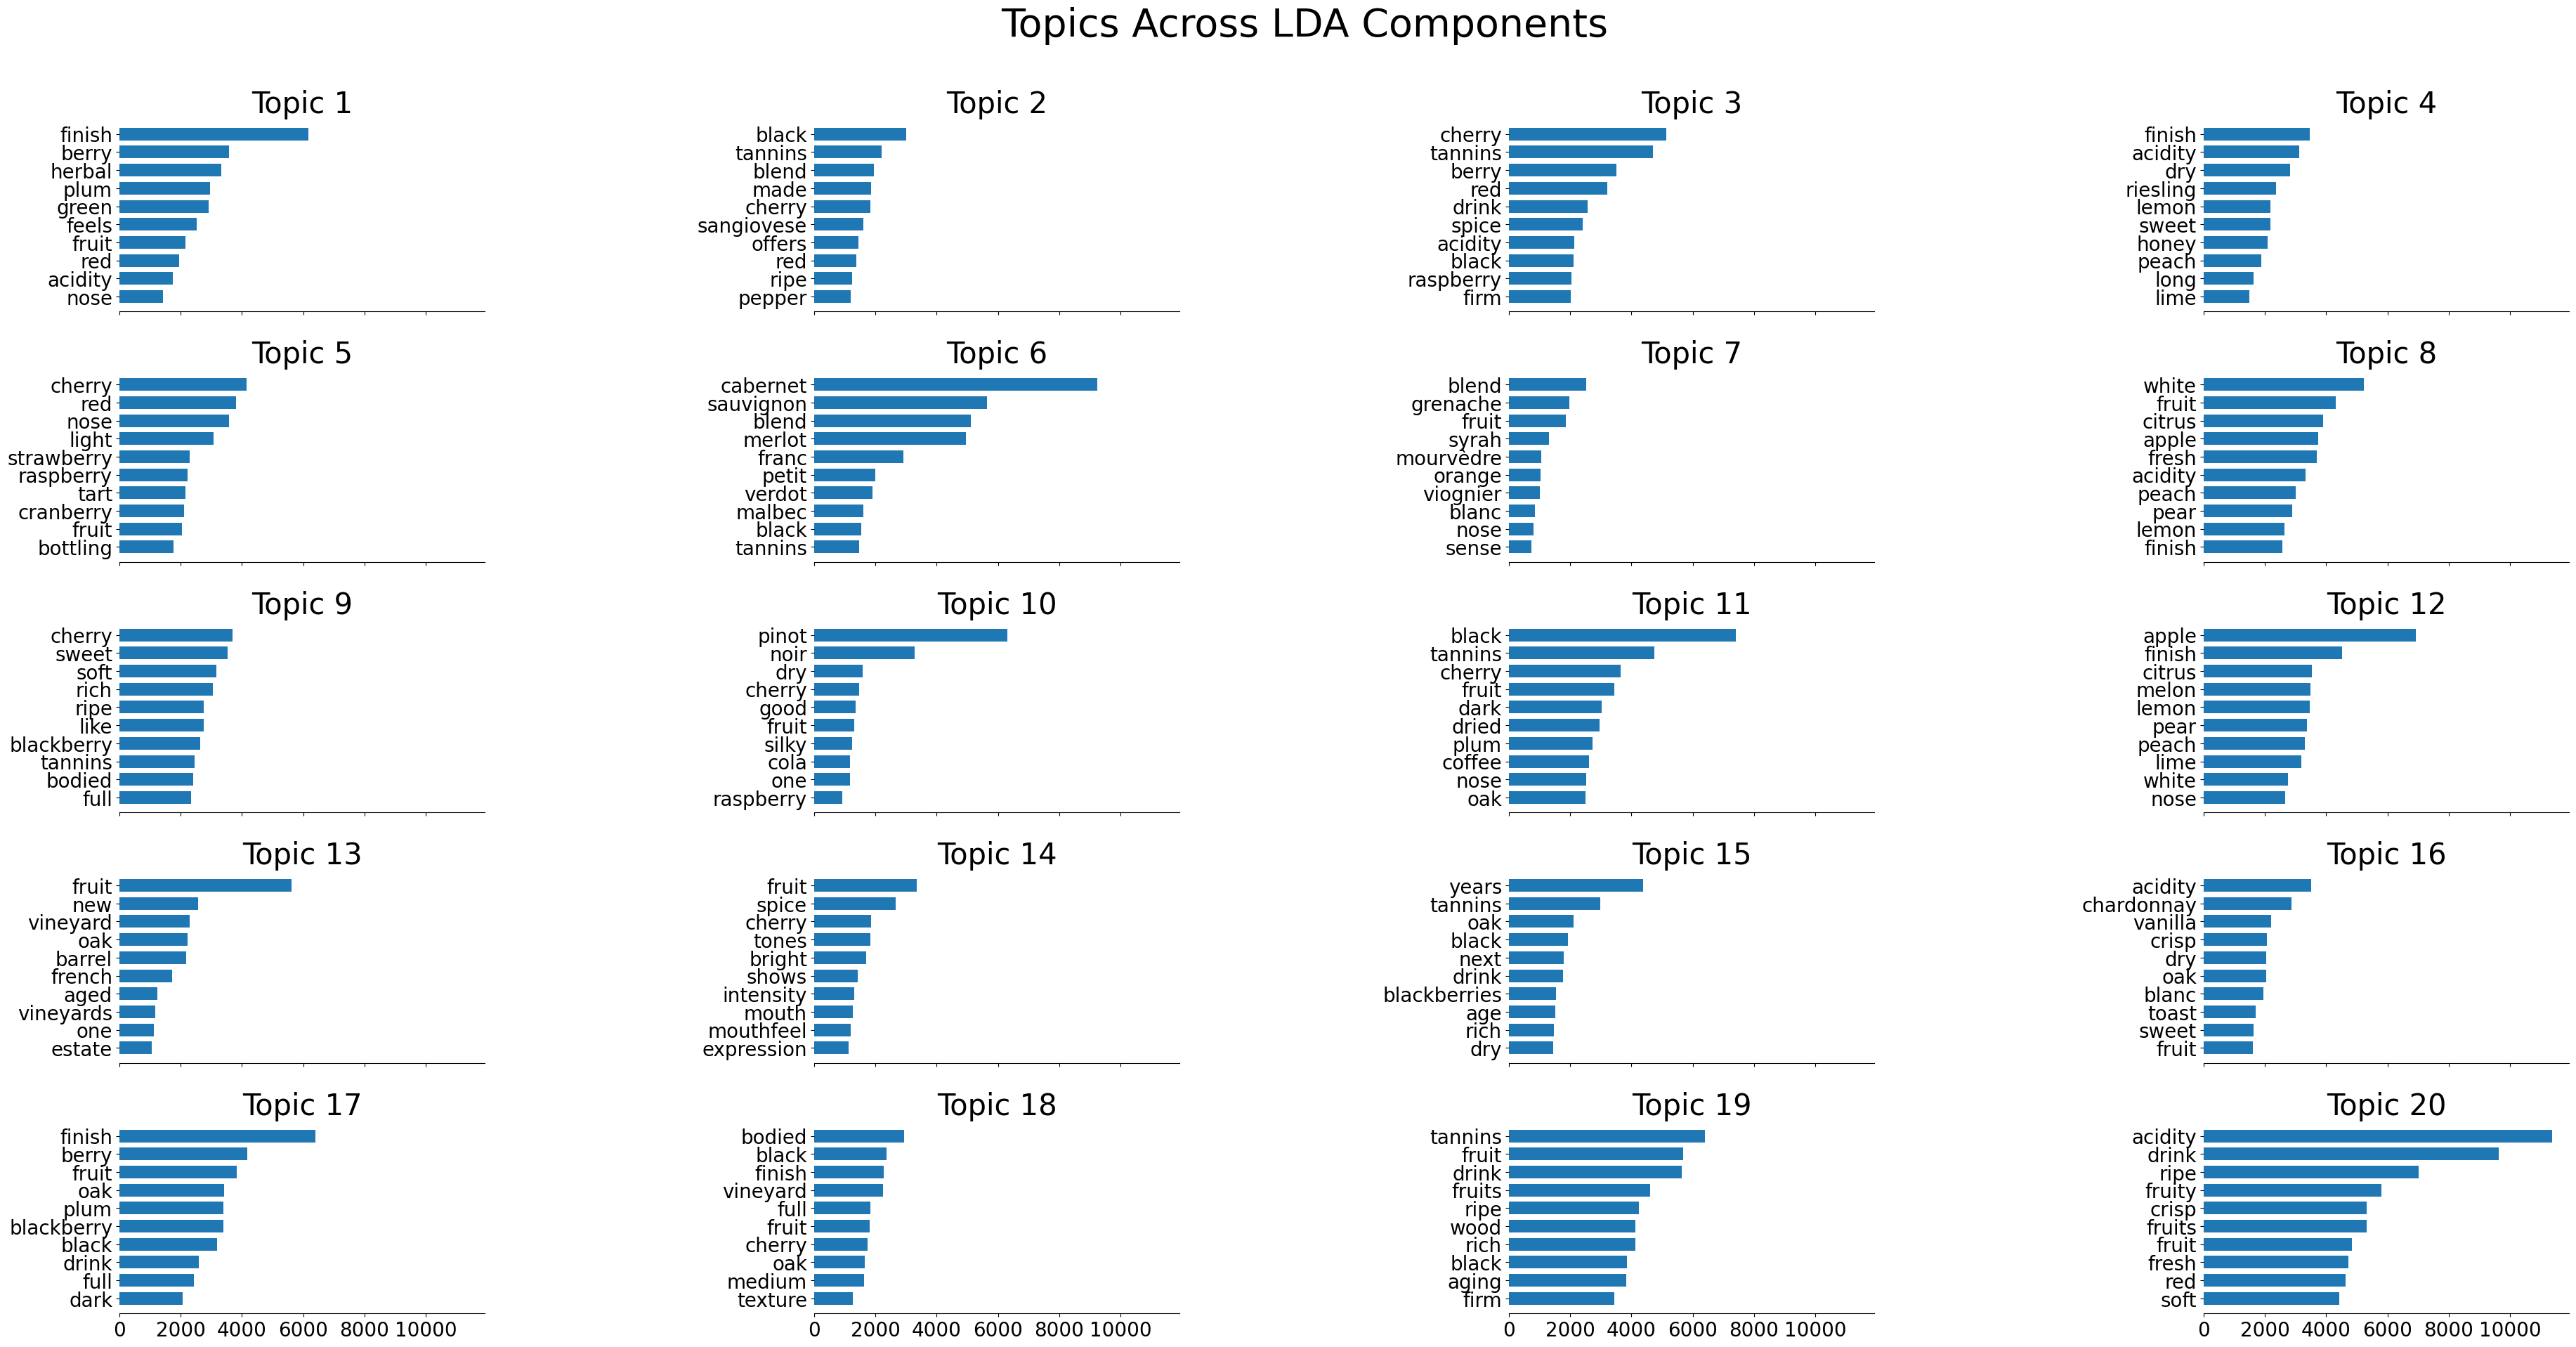

In [33]:
n_components = 20
n_top_words = 10
feature_names = updated_vectorizer.get_feature_names_out()
plot_top_words(lda_model_updated, feature_names, n_top_words, "Topics Across LDA Components")

After excluding wine-specific stopwords, we are starting to see clearer boundaries between components.

## Word2Vec modeling

In [34]:
# Reset X and y
X = df['clean']
y = df['points']

In [35]:
# We'll use a 70/30 train/test split again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [36]:
X_train[0]

'aromas include tropical fruit  broom  brimstone and dried herb  the palate isn t overly expressive  offering unripened apple  citrus and dried sage alongside brisk acidity '

In [37]:
# Tokenize and remove stopwords
X_train = X_train.apply(remove_wine_stopwords)
X_test = X_test.apply(remove_wine_stopwords)

In [38]:
X_train[0]

['include',
 'tropical',
 'fruit',
 'broom',
 'brimstone',
 'dried',
 'herb',
 'overly',
 'expressive',
 'offering',
 'unripened',
 'apple',
 'citrus',
 'dried',
 'sage',
 'alongside',
 'brisk',
 'acidity']

In [40]:
# Instantiate Word2Vec model
wv_model = Word2Vec(sentences=X_train, vector_size=50, window=5, min_count=3)

In [41]:
# Check that the model makes sense by testing a few features
wv_model.wv.doesnt_match(['strawberry', 'cherry', 'berry', 'smoke'])

'smoke'

In [42]:
# Determines the words that are most similar to 'young'
wv_model.wv.most_similar('young')

[('youthful', 0.7950202226638794),
 ('developing', 0.6210610866546631),
 ('tight', 0.6192448735237122),
 ('primary', 0.6182070970535278),
 ('resolving', 0.6172664165496826),
 ('needs', 0.6119322776794434),
 ('although', 0.5787216424942017),
 ('need', 0.5765204429626465),
 ('ready', 0.5763920545578003),
 ('monstrous', 0.5419217944145203)]

In [43]:
wv_model.wv.most_similar('thin')

[('watery', 0.8578742742538452),
 ('dilute', 0.7903569340705872),
 ('generic', 0.7057166695594788),
 ('prickly', 0.7035542726516724),
 ('disjointed', 0.7020618319511414),
 ('lean', 0.701697051525116),
 ('harsh', 0.6979811191558838),
 ('simple', 0.6976593136787415),
 ('confected', 0.6934478282928467),
 ('somewhat', 0.6868817210197449)]

In [44]:
# Arithmetic with word vectors
# In simple terms, it finds words that are similar to 'herbaceous' but not 'earthy'
# It finds vinho verde, a traditionally herbaceous but not earthy wine!
v_herbaceous = wv_model.wv['herbaceous']
v_earthy = wv_model.wv['earthy']
v_result = v_herbaceous - v_earthy
wv_model.wv.similar_by_vector(v_result)

[('blancs', 0.6421399712562561),
 ('arinto', 0.6386748552322388),
 ('alvarinho', 0.62122642993927),
 ('chablis', 0.6114034056663513),
 ('pires', 0.5955897569656372),
 ('champagne', 0.5874923467636108),
 ('vinho', 0.5833519101142883),
 ('vaz', 0.5796159505844116),
 ('steeliness', 0.5761945247650146),
 ('fernão', 0.5621582865715027)]

In [45]:
wv_model.save('../models/wv_model2.model')

In [46]:
# Function to convert a sentence into a matrix
def embed_sentence(wv_model, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in wv_model.wv:
            embedded_sentence.append(wv_model.wv[word])
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)  
    return embed

In [47]:
# Embed sentences
X_train_embed = embedding(wv_model, X_train)
X_test_embed = embedding(wv_model, X_test)

In [48]:
# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post')
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post')

## Long Short-Term Memory (LSTM) model to predict points based on reviews

The goal of this LSTM model is to predict the points a wine would be rated (e.g. 92 out of 100) based on its review.

In [51]:
# Initializes an LSTM model
def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(loss='mse',
                  optimizer='rmsprop',
                  metrics=['mse'])
    return model

In [53]:
model = init_model()

In [ ]:
# Trains the model
es = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train_pad, y_train, 
          batch_size=32,
          epochs=100,
          validation_split=0.3,
          callbacks=es
         )

Epoch 1/100
1990/1990 [==============================] - 51s 17ms/step - loss: 964.7054 - mse: 964.7054 - val_loss: 4.1349 - val_mse: 4.1349
Epoch 2/100
1990/1990 [==============================] - 22s 11ms/step - loss: 3.8968 - mse: 3.8968 - val_loss: 4.3738 - val_mse: 4.3738
Epoch 3/100
1990/1990 [==============================] - 23s 11ms/step - loss: 3.5596 - mse: 3.5596 - val_loss: 4.0301 - val_mse: 4.0301
Epoch 4/100
1990/1990 [==============================] - 22s 11ms/step - loss: 3.4198 - mse: 3.4198 - val_loss: 3.5292 - val_mse: 3.5292
Epoch 5/100
1990/1990 [==============================] - 23s 12ms/step - loss: 3.3337 - mse: 3.3337 - val_loss: 3.3519 - val_mse: 3.3519
Epoch 6/100
1990/1990 [==============================] - 24s 12ms/step - loss: 3.2834 - mse: 3.2834 - val_loss: 3.4837 - val_mse: 3.4837
Epoch 7/100
1990/1990 [==============================] - 22s 11ms/step - loss: 3.2452 - mse: 3.2452 - val_loss: 3.7628 - val_mse: 3.7628
Epoch 8/100
1990/1990 [==============

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 50)          0         
                                                                 
 lstm (LSTM)                 (None, 20)                5680      
                                                                 
 dense (Dense)               (None, 15)                315       
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 6,011
Trainable params: 6,011
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Saves model
model.save('/content/drive/MyDrive/Colab Notebooks/wine_prices/model1.h5')

In [ ]:
train_score = model.evaluate(X_train_pad, y_train)
print('The training score is {:.2f}'.format(train_score[0]))

2842/2842 [==============================] - 13s 5ms/step - loss: 2.9661 - mse: 2.9661
The training score is 2.97


In [ ]:
test_score = model.evaluate(X_test_pad, y_test)
print('The test score is {:.2f}'.format(test_score[0]))

1218/1218 [==============================] - 11s 7ms/step - loss: 3.0486 - mse: 3.0486
The test score is 3.05


## LSTM for price prediction based on reviews

In [29]:
# Reset X and y and use df_no_outliers
df_no_outliers = Data.no_outliers(df)
X = df_no_outliers['clean']
y = df_no_outliers['price']

In [ ]:
# We'll use a 70/30 train/test split again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
# Tokenize and remove stopwords
X_train = X_train.apply(remove_wine_stopwords)
X_test = X_test.apply(remove_wine_stopwords)

In [ ]:
# Embed sentences
X_train_embed = embedding(wv_model, X_train)
X_test_embed = embedding(wv_model, X_test)

In [ ]:
# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post')
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post')

In [ ]:
# Initializes an LSTM model for price prediction
optimizer = Adam(learning_rate=0.0005)
def init_price_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(32, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse'])
    return model

In [ ]:
price_model = init_price_model()

In [ ]:
filepath = '/content/drive/MyDrive/Colab Notebooks/wine_prices/model.{epoch:02d}-{val_loss:.2f}.h5'

# Trains the model
es = [EarlyStopping(patience=5, restore_best_weights=True),
      ModelCheckpoint(filepath=filepath, save_best_only=True)]

price_model.fit(X_train_pad, y_train, 
          batch_size=32,
          epochs=100,
          validation_split=0.3,
          callbacks=es
         )

Epoch 1/100
1947/1947 [==============================] - 431s 220ms/step - loss: 502.5479 - mse: 502.5479 - val_loss: 304.0623 - val_mse: 304.0623
Epoch 2/100
1947/1947 [==============================] - 438s 225ms/step - loss: 313.3172 - mse: 313.3172 - val_loss: 269.4745 - val_mse: 269.4745
Epoch 3/100
1947/1947 [==============================] - 428s 220ms/step - loss: 289.2317 - mse: 289.2317 - val_loss: 256.8922 - val_mse: 256.8922
Epoch 4/100
1947/1947 [==============================] - 435s 223ms/step - loss: 276.3782 - mse: 276.3782 - val_loss: 251.7168 - val_mse: 251.7168
Epoch 5/100
1947/1947 [==============================] - 433s 223ms/step - loss: 269.3625 - mse: 269.3625 - val_loss: 247.0752 - val_mse: 247.0752
Epoch 6/100
1947/1947 [==============================] - 424s 218ms/step - loss: 262.7778 - mse: 262.7778 - val_loss: 244.5578 - val_mse: 244.5578
Epoch 7/100
1947/1947 [==============================] - 424s 218ms/step - loss: 258.5233 - mse: 258.5233 - val_loss: 